# Saliancy Maps on the model "Accurate Spectral Super-Resolution from Single RGB Image Using Multi-scale CNN"
### It is a U-Net based model that takes an RGB image and outputs a 31 bands spectral image

## Initial code setup

In [2]:
import os
import cv2
import numpy as np
import torch
from torchvision import models
from IPython.display import Image
import torch.nn as nn

Lets load things we need for **Grad-CAM**

In [3]:
from torchvision.utils import make_grid, save_image
import torch.nn.functional as F

from gradcam.utils import visualize_cam
from gradcam import GradCAMpp, GradCAM

# The GradCAM kit throws a warning we don't need to see for this demo. 
import warnings
warnings.filterwarnings('ignore')

Now we import the code for **this package**.

In [4]:
import maps
import mask
import draw
import norm
import misc

Importing for the other U-Net model package 

In [5]:
from model import Model # my model
from model_ref import Model_Ref # Fully Conv DenseNet
from utilities import *
import types

This is where we can set some parameters like the image name and the layer weights.

In [12]:
# input_image_name    = "ILSVRC2012_val_00049934.224x224.png"     # Our input image to process 
path = './testSet2/' # path to the test input images

output_dir          = 'outputs2'                                 # Where to save our output images
input_dir           = 'images'                                  # Where to load our inputs from

weightsSR             = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                 # Equal Weights work best 
                                                                # when using with GradCAM
    
#weights             = [0.18, 0.15, 0.37, 0.4, 0.72]            # Our saliency layer weights 
                                                                # From paper:
                                                                # https://arxiv.org/abs/1911.11293

# save_prefix         = input_image_name[:-4].split('/')[-1]      # Chop the file extension and path
# load_image_name     = os.path.join(input_dir, input_image_name)
new_test_image = 'ARAD_1K_0901.jpg'

device              = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.makedirs(output_dir, exist_ok=True)

In [8]:
opt = types.SimpleNamespace()
opt.preprocess = False
opt.logs = "TestLog"
opt.size = 1280
opt.model = 'Model'
opt.dropout = 0

## network architecture
rgb_features = 3
pre_features = 64
hyper_features = 31
growth_rate = 16
negative_slope = 0.2

This block is for the U-Net super resolution model

In [9]:
## build model
print("building models ...\n")
if opt.model == 'Model':
    print("Our model, Dropout rate 0.%d\n" % opt.dropout)
    net = Model(
        input_features = rgb_features,
        output_features = hyper_features,
        negative_slope = negative_slope,
        p_drop = 0
    )
elif opt.model == 'Ref':
    print("Reference model FC-DenseNet, Dropout rate 0.%d\n" % opt.dropout)
    net = Model_Ref(
        input_features = rgb_features,
        pre_features = pre_features,
        output_features = hyper_features,
        db_growth_rate = growth_rate,
        negative_slope = negative_slope,
        p_drop = 0
    )
else:
    raise Exception("Invalid model name!", opt.model)
# move to GPU
device_ids = [0,1,2,3,4,5,6,7]
model = nn.DataParallel(net, device_ids=device_ids)#.cuda()
model.load_state_dict(torch.load(os.path.join(opt.logs, 'net_%s_%02d.pth'%(opt.model,opt.dropout) ), map_location=torch.device('cpu')))

building models ...

Our model, Dropout rate 0.0



<All keys matched successfully>

In [10]:
hooks   = [misc.CaptureLayerOutput() for i in range(9)]   # Create 9 callback hooks in a list
map_num = len(hooks)                                      # Store size for later use

# Chopin off the "_ =" is fine. We technically don't 
# need anything bach but the handel to each hook. 
_ = model.module.in_conv.conv[6].register_forward_hook(hooks[0])
_ = model.module.down1.down[2].conv[6].register_forward_hook(hooks[1])
_ = model.module.down2.down[2].conv[6].register_forward_hook(hooks[2])
_ = model.module.down3.down[2].conv[6].register_forward_hook(hooks[3])
_ = model.module.bottleneck.down[2].conv[6].register_forward_hook(hooks[4])
_ = model.module.up1.conv[1].conv[6].register_forward_hook(hooks[5])
_ = model.module.up2.conv[1].conv[6].register_forward_hook(hooks[6])
_ = model.module.up3.conv[1].conv[6].register_forward_hook(hooks[7])
_ = model.module.out_conv.conv[1].conv[6].register_forward_hook(hooks[8])

In [17]:
for (root, dirs, file) in os.walk(path):
    for f in file:

        # input the image from the test folder
        in_tensor   = misc.LoadImageToTensor(path + f, device)
        in_tensor   = F.interpolate(in_tensor, size=(480, 512), mode='bilinear', align_corners=False)
        save_prefix = f[:-4]

        in_height   = in_tensor.size()[2]
        in_width    = in_tensor.size()[3]

        # run the forward pass on the model
        model.eval()
        with torch.set_grad_enabled(False):
            _ = model(in_tensor)

        # get the combined saliancy maps from the hooks
        getSmap     = maps.SMOEScaleMap(run_relu=True)
        #getNorm     = norm.GaussNorm2D()
        getNorm     = norm.GammaNorm2D() # A little more accurate, but much slower
        getCsmap    = maps.CombineSaliencyMaps(output_size=[in_height,in_width], 
                                       map_num=map_num, weights=weightsSR, resize_mode='bilinear')
        smaps       = [ getNorm(getSmap(x.data)) for x in hooks ]   
        csmap,smaps = getCsmap(smaps)

        # save and view the saliancy map
        output_name = "{}.MAP_COMBINED.jpg".format(save_prefix)
        output_path = os.path.join(output_dir, output_name)
        misc.SaveGrayTensorToImage(csmap, output_path)
        np_smaps    = misc.TensorToNumpyImages(smaps) # For later use, keep the Numpy version 
                                                    # of the saliency maps.

        Image(filename=output_path)

This block is to run on only one image 

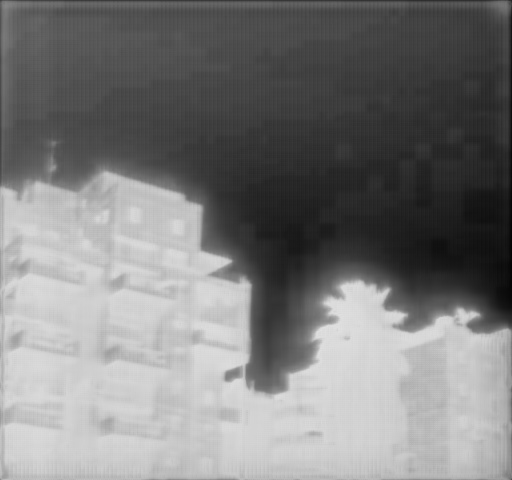

In [17]:
# input the image from the test folder
in_tensor   = misc.LoadImageToTensor(new_test_image, device)
in_tensor   = F.interpolate(in_tensor, size=(480, 512), mode='bilinear', align_corners=False)
save_prefix = new_test_image[:-4]

in_height   = in_tensor.size()[2]
in_width    = in_tensor.size()[3]

# run the forward pass on the model
model.eval()
with torch.set_grad_enabled(False):
    _ = model(in_tensor)

# get the combined saliancy maps from the hooks
getSmap     = maps.SMOEScaleMap(run_relu=True)
#getNorm     = norm.GaussNorm2D()
getNorm     = norm.GammaNorm2D() # A little more accurate, but much slower
getCsmap    = maps.CombineSaliencyMaps(output_size=[in_height,in_width], 
                                map_num=map_num, weights=weightsSR, resize_mode='bilinear')
smaps       = [ getNorm(getSmap(x.data)) for x in hooks ]   
csmap,smaps = getCsmap(smaps)

# save and view the saliancy map
output_name = "{}.MAP_COMBINED.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)
misc.SaveGrayTensorToImage(csmap, output_path)
np_smaps    = misc.TensorToNumpyImages(smaps) # For later use, keep the Numpy version 
                                            # of the saliency maps.

Image(filename=output_path)

Now lets get our individual saliency maps for each of the five layers and look at them. 

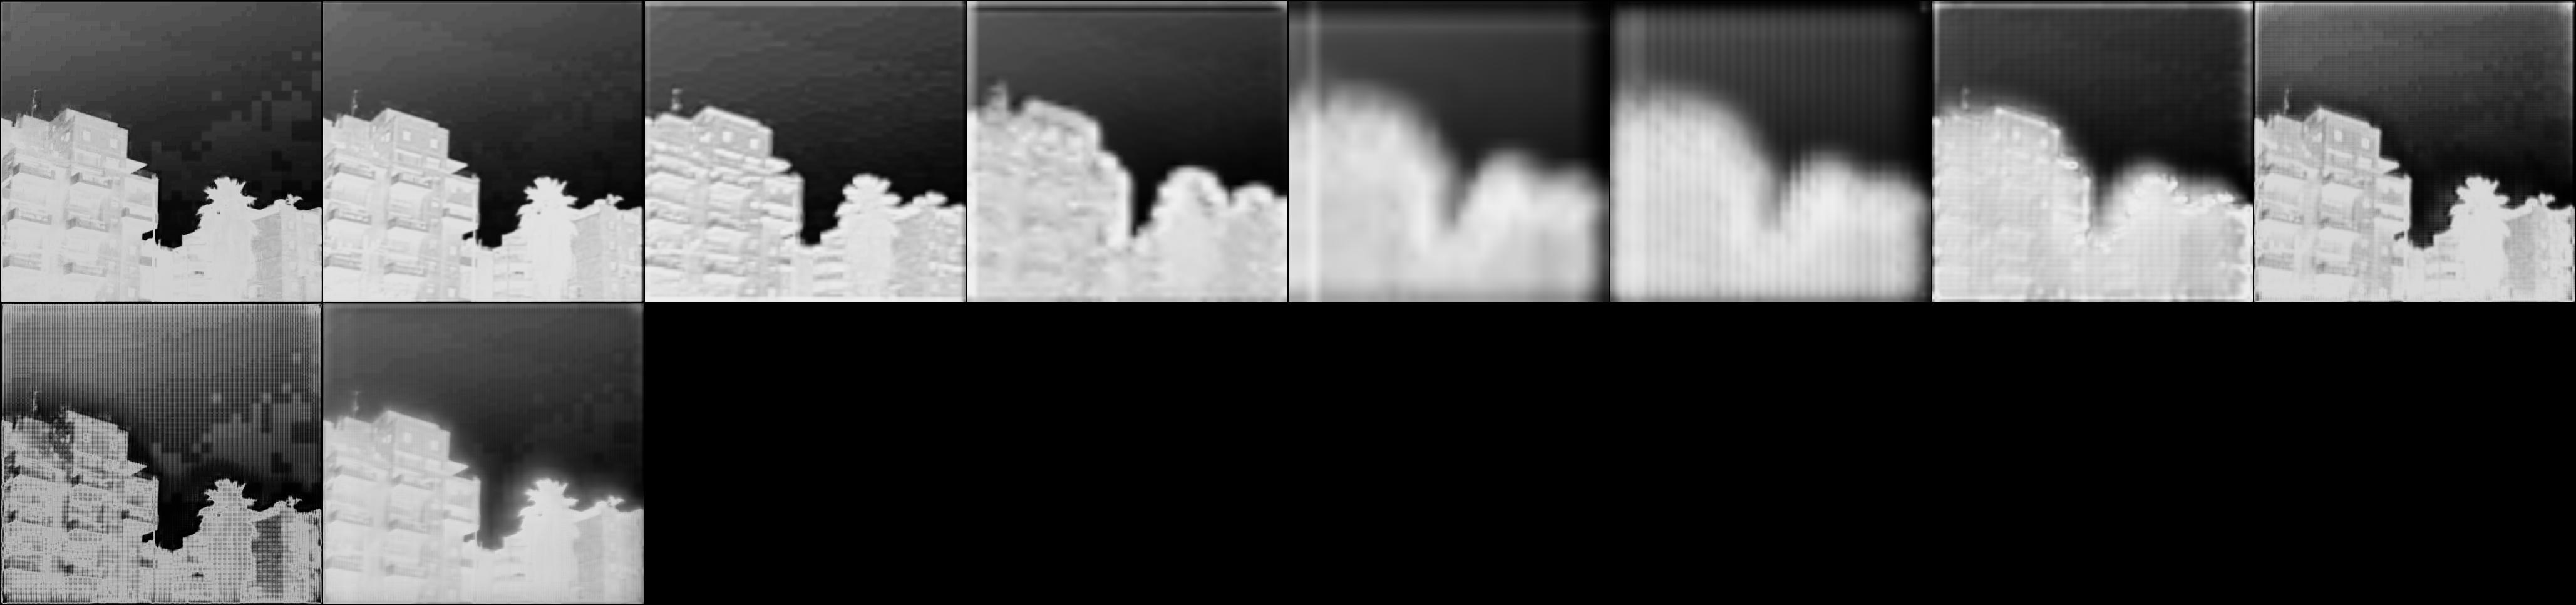

In [109]:
il = [smaps[0,i,:,:] for i in range(map_num)] # Put each saliency map into the figure
    
il.append(csmap[0,:,:])                       # add in the combined map at the end of the figure

images        = [torch.stack(il, 0)]          
images        = make_grid(torch.cat(images, 0), nrow=9)
output_name   = "{}.SAL_MAPS.jpg".format(save_prefix)
sal_img_file  = os.path.join(output_dir, output_name)

save_image(images.unsqueeze(1), sal_img_file)

Image(filename=sal_img_file) 

## LOVI and Heat Maps
Now we will take our saliency maps and create the LOVI and Heat Map versions.

In [18]:
SHM         = draw.HeatMap(shape=np_smaps.shape, weights=weightsSR )  # Create our heat map drawer
LOVI        = draw.LOVI(shape=np_smaps.shape, weights=None)         # Create out LOVI drawer

shm_im      = SHM.make(np_smaps)                                    # Combine the saliency maps 
                                                                    # into one heat map
lovi_im     = LOVI.make(np_smaps)                                   # Combine the saliency maps 
                                                                    # into one LOVI image

Next, save and display our images. 

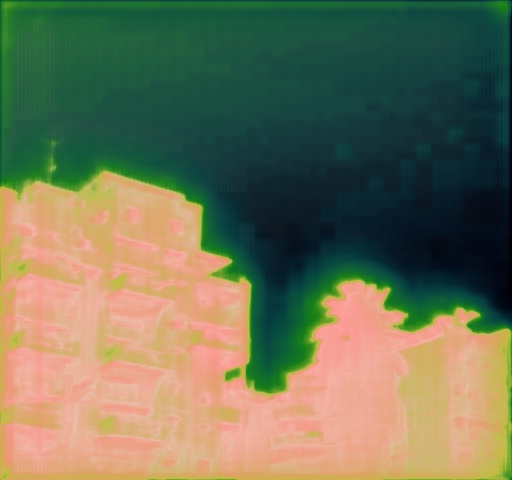

In [19]:
output_name = "{}.HEAT.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (shm_im*255.0).astype(np.uint8))

Image(filename=output_path) 

Let's create on overlay with our original image by alpha blending. 

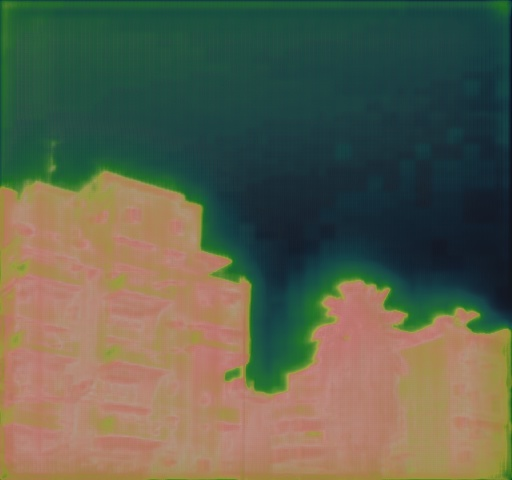

In [22]:
cv_im         = cv2.imread(new_test_image).astype(np.float32) / 255.0
cv_im         = cv2.resize(cv_im, (512,480))
ab_shm        = misc.AlphaBlend(shm_im, cv_im) # Blend the heat map and the original image

output_name   = "{}.ALPHA_HEAT.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (ab_shm*255.0).astype(np.uint8)) 

Image(filename=output_path) 

Now we view our LOVI map with and without alpha blending of the original image. The LOVI image tells us which parts of the network are most active by layer. We range like a rainbow with violet/blue representing early layers and yellow/red representing later layers. White areas are active over all layers. 

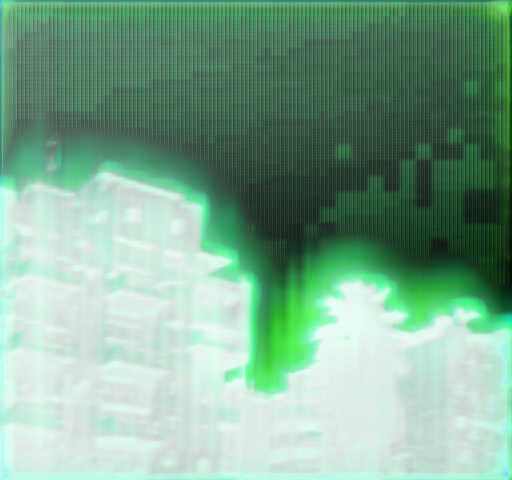

In [23]:
output_name   = "{}.LOVI.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (lovi_im*255.0).astype(np.uint8))

Image(filename=output_path) 

You can see how this image is composed by looking again at all the individual saliency maps...

In [ ]:
Image(filename=sal_img_file)

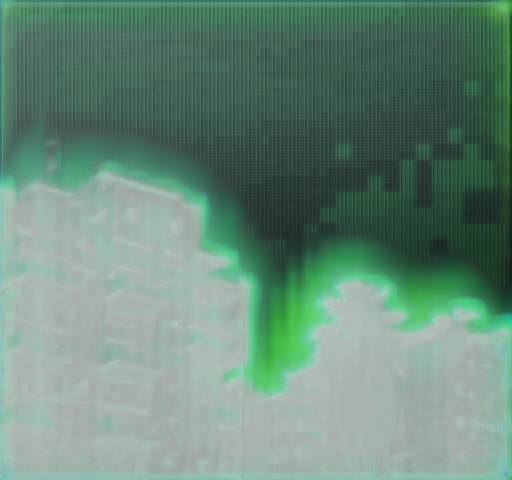

In [30]:
ab_lovi       = misc.AlphaBlend(lovi_im, cv_im) # Blend original image and LOVI image

output_name   = "{}.ALPHA_LOVI.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (ab_lovi*255.0).astype(np.uint8)) 

Image(filename=output_path) 

## The Masked Image
From the combined saliency map, we can extract the masked out input image. This illustrates What parts of the image are the top xx% most salient. 

First we set up objects to create the mask from the input tensor version of the image and the combined saliency map.

In [25]:
getMask                 = mask.SaliencyMaskDropout(keep_percent = 0.1, scale_map=False)

We define a denormalization object to get things back to normal image pixel values. 

In [26]:
denorm                  = misc.DeNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Next we process the tensor and saliency map to create the masked image.  

In [27]:
masked_tensor,drop_map  = getMask(in_tensor, csmap)

Finally, we denormalize the tensor image, save and display it. This shows us the **top 10% most salient parts** of the images.

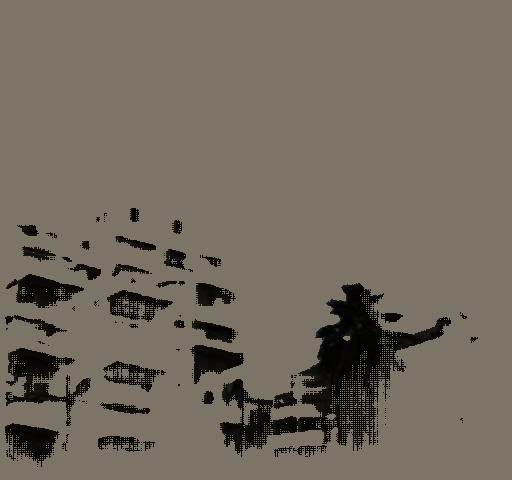

In [28]:
masked_tensor = denorm(masked_tensor)

output_name   = "{}.MASK.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
misc.SaveColorTensorToImage(masked_tensor, output_path)
Image(filename=output_path) 

## Run With Grad-CAM++

Let's go ahead and push our network model into the Grad-CAM library.

**NOTE** much of this code is borrowed from the Pytorch GradCAM package. 

In [ ]:
resnet_gradcampp4   = GradCAMpp.from_config(model_type='resnet', arch=model, layer_name='layer4')

Let's get our original input image back.

In [30]:
raw_tensor   = misc.LoadImageToTensor(load_image_name, device, norm=False)
raw_tensor   = F.interpolate(raw_tensor, size=(224, 224), mode='bilinear', align_corners=False)

Now we will create illustrations of the combined saliency map. 

In [31]:
masked_tensor_raw,drop_map = getMask(raw_tensor, csmap)

cs_heatmap, cs_result      = visualize_cam(csmap, raw_tensor)
cs_masked                  = misc.AlphaMask(raw_tensor, csmap).squeeze(0)
cs_masked                  = misc.RangeNormalize(cs_masked)

images = []
images.append(torch.stack([raw_tensor.squeeze().cpu(), cs_heatmap.cpu(), 
                           cs_result.cpu(), cs_masked.cpu(), masked_tensor_raw[0,].cpu()], 0))

Now, lets get the Grad-CAM++ saliency map only.

In [32]:
mask_pp1, logit             = resnet_gradcampp4(in_tensor)

Let's double check and make sure it's picking the correct class

In [33]:
too_logit = logit.max(1)
print("Network Class Output: {} : Value {} ".format(too_logit[1][0],too_logit[0][0]))

Network Class Output: 222 : Value 16.05866050720215 


Now visualize the results

In [34]:
heatmap_pp1, result_pp1 = visualize_cam(mask_pp1, raw_tensor)

hard_masked_pp1,_       = getMask(raw_tensor, mask_pp1.squeeze(0))
hard_masked_pp1         = hard_masked_pp1.squeeze(0)
masked_pp1              = misc.AlphaMask(raw_tensor, mask_pp1.squeeze(0)).squeeze(0)
masked_pp1              = misc.RangeNormalize(masked_pp1)

images.append(torch.stack([raw_tensor.squeeze().cpu(), heatmap_pp1.cpu(), 
                           result_pp1.cpu(), masked_pp1.cpu(), hard_masked_pp1.cpu()], 0))

**Now we combine the Grad-CAM map and the SMOE Scale saliency maps** in the same way we would combine Grad-CAM with Guided Backprop.

In [35]:
mask_pp2                = csmap*mask_pp1

Now let's visualize the combined saliency map from SMOE Scale and GradCAM++.

In [36]:
heatmap_pp2, result_pp2 = visualize_cam(mask_pp2, raw_tensor)

hard_masked_pp2,_       = getMask(raw_tensor,mask_pp2.squeeze(0))
hard_masked_pp2         = hard_masked_pp2.squeeze(0)
masked_pp2              = misc.AlphaMask(raw_tensor, mask_pp2.squeeze(0)).squeeze(0)
masked_pp2              = misc.RangeNormalize(masked_pp2)

images.append(torch.stack([raw_tensor.squeeze().cpu(), heatmap_pp2.cpu(), 
                           result_pp2.cpu(), masked_pp2.cpu(), hard_masked_pp2.cpu()], 0))

Now we combine the Grad-CAM map and the SMOE Scale saliency maps but create a map of the **non-class** objects. These are salient locations that the network found interesting, but are not part of the object class. 

In [37]:
mask_pp3                = csmap*(1.0 - mask_pp1)

Now let's visualize the combined non-class saliency map from SMOE Scale and GradCAM++.

In [38]:
heatmap_pp3, result_pp3 = visualize_cam(mask_pp3, raw_tensor)

hard_masked_pp3,_       = getMask(raw_tensor,mask_pp3.squeeze(0))
hard_masked_pp3         = hard_masked_pp3.squeeze(0)
masked_pp3              = misc.AlphaMask(raw_tensor, mask_pp3.squeeze(0)).squeeze(0)
masked_pp3              = misc.RangeNormalize(masked_pp3)

images.append(torch.stack([raw_tensor.squeeze().cpu(), heatmap_pp3.cpu(), 
                           result_pp3.cpu(), masked_pp3.cpu(), hard_masked_pp3.cpu()], 0))

We now put all the images into a nice grid for display.

In [39]:
images = make_grid(torch.cat(images,0), nrow=5)

... save and look at it. 

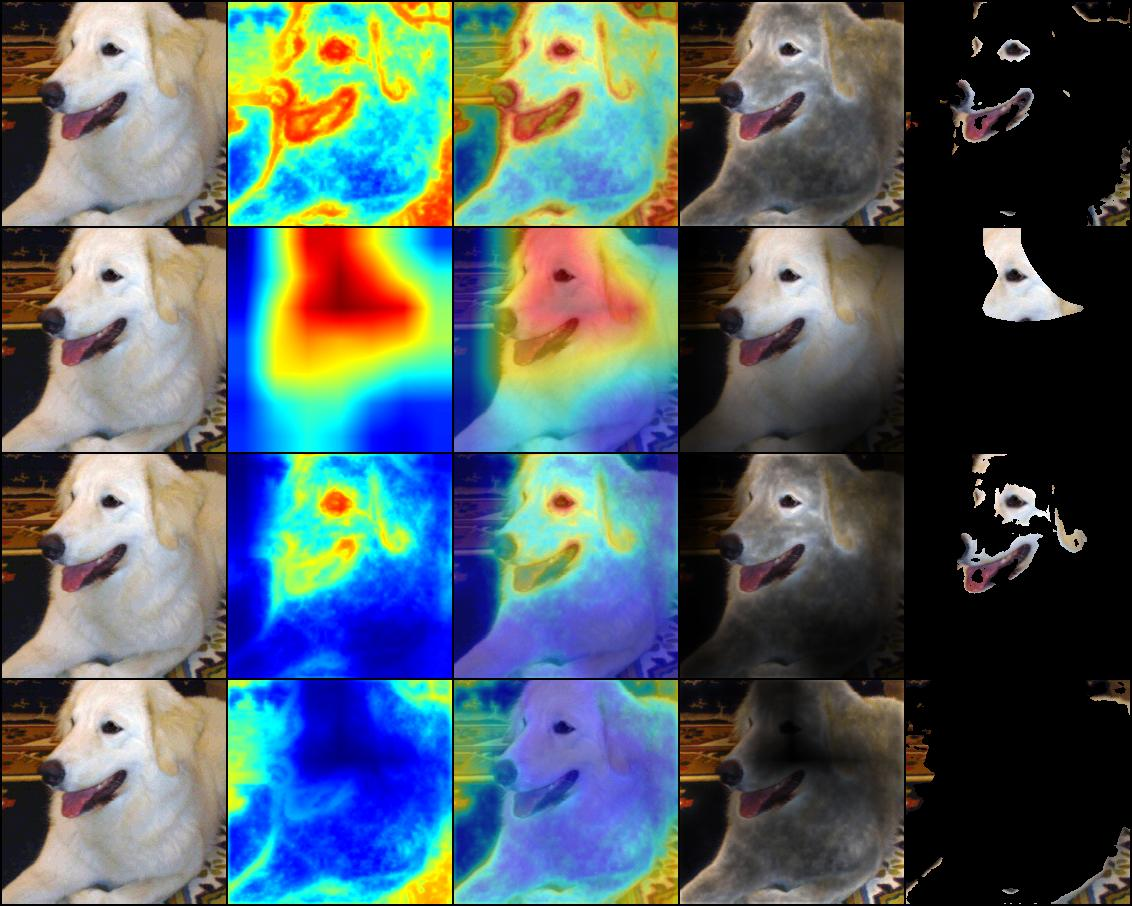

In [40]:
output_name = "{}.CAM_PP.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
Image(filename=output_path) 

The top row is the SMOE Scale based saliency map. The second row is GradCAM++ only. Next we have the FastCAM output from combining the two. The last row is the non-class map showing salient regions that are not associated with the output class.

This image should look **exactly** like the one on the README.md on Github minus the text. 